> **This notrbook is used for finding a suitable step size for random cluster splitting.**

 > **How splitting works:**
 - sortes clusters by the number of samples
 - groups clusters with similar number of samples (group 0: clusters with less than 5 samples, etc)
 - randomly selects "ratio" (eg. 20%) of the clusters in each group and adds them to test

 > this ensures that not all small/large clusters are in one set

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/MRSA\ datasets

Mounted at /content/drive
/content/drive/MyDrive/MRSA datasets


In [ ]:
root_dir = '/content/drive/MyDrive/MRSA datasets'
table_dir =  'Tables/Models Tables/' # 'Tables/Models Tables Homology/'
table_names = {'Escherichia_coli': 'Escherichia coli_Model_Table_clusters.csv',
              'Salmonella' : 'Salmonella enterica_Model_Table_clusters.csv',
              'Staphylococcus': 'Staphylococcus aureus_Model_Table_clusters.csv',
              'General_Model' : 'General_Model_Table_clusters.csv',
              'Escherichia_coli_General_Model': 'Escherichia coli_Species_Model_Table_clusters.csv',
              'Salmonella_General_Model' : 'Salmonella enterica_Species_Model_Table_clusters.csv',
              'Staphylococcus_General_Model': 'Staphylococcus aureus_Species_Model_Table_clusters.csv'}

homology_dir = 'Homology_splitting/'

final_table_dir = homology_dir # we can change it later to Metadata Tables/Experimental

MODEL = 'General_Model'
TABLE = table_dir + table_names[MODEL]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from collections import defaultdict
import random

In [ ]:
table_df = pd.read_csv(TABLE)
table_df['row_index'] = table_df.index

def get_clusters_labels(df, i):
    cluster = df[df['clusters'] == i]
    return ((cluster == 'S').sum()).tolist()[:-1], ((cluster == 'R').sum()).tolist()[:-1], len(cluster)

clusters = {}

for c in table_df['clusters'].unique():
    _, _, count = get_clusters_labels(table_df[table_df.columns[3:]], c)
    clusters[c] = count

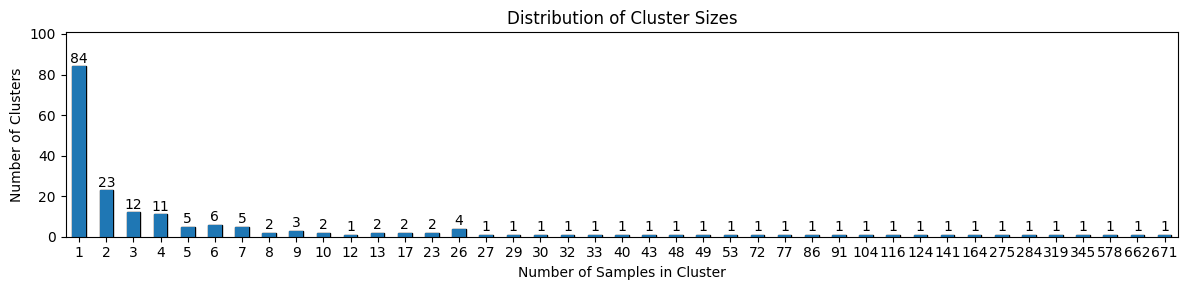

In [ ]:
# counts = [v['count'] for v in clusters.values()]
counts = clusters.values()
cluster_counts = pd.Series(counts).value_counts().sort_index()

plt.figure(figsize = (12,3))
ax = cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

cluster_counts.plot(kind='bar')
plt.xlabel('Number of Samples in Cluster')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Sizes')
y_max = cluster_counts.max()
plt.ylim(0, y_max + y_max * 0.2)
plt.xticks(rotation = 0)

for i, val in enumerate(cluster_counts):
    ax.text(i, val + 0.2, str(val), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [ ]:
len(cluster_counts)

41

> select step size relative to number of groups (len(cluster_counts))

In [ ]:
# sort custer ascendingly
# group by 5
# randomly select x from each group

In [ ]:
step = 5
ratio = 0.2
seed = 42

In [ ]:
clusters_column = table_df['clusters'].tolist()
clusters = defaultdict(list)
for i in range(len(table_df)):
    clusters[clusters_column[i]].append(i)

clusters_copy = clusters.copy()

clusters_groups = defaultdict(list)
for i in range(step,len(cluster_counts) - step, step):
    for key, values in list(clusters_copy.items()):
        if len(values) < cluster_counts.index[i]:
            clusters_groups[i/step].append(key)
            clusters_copy.pop(key, None)

In [ ]:
for key, values in clusters_groups.items():
    print(f"group {key}:    {len(values)}")

group 1.0:    135
group 2.0:    18
group 3.0:    11
group 4.0:    5
group 5.0:    5
group 6.0:    5
group 7.0:    5


In [ ]:
for key, values in clusters_groups.items():
    random.seed(seed)
    print(random.sample(clusters_groups[key], k = int(len(values)*ratio)))

[146, 94, 81, 72, 144, 52, 23, 133, 165, 170, 47, 119, 154, 104, 156, 102, 28, 42, 123, 157, 151, 111, 74, 68, 162, 160, 114]
[91, 60, 70]
[51, 57]
[41]
[30]
[17]
[3]


In [ ]:
test_clusters = []

for key, values in clusters_groups.items():
    random.seed(seed)
    test_clusters.extend(random.sample(clusters_groups[key], k = int(len(values)*ratio)))
train_clusters = [c for c in clusters.keys() if c not in test_clusters]

In [ ]:
clusters_column = table_df['clusters'].tolist()
clusters = defaultdict(list)
for i in range(len(table_df)):
    clusters[clusters_column[i]].append(i)


clusters_size = {}

for c in table_df['clusters'].unique():
    _, _, count = get_clusters_labels(table_df[table_df.columns[3:]], c)
    clusters_size[c] = count

In [ ]:
def split_function(clusters, clusters_size, ratio = 0.2):
    clusters_size = clusters.values()
    cluster_counts = pd.Series(clusters_size).value_counts().sort_index()
    step = int(len(cluster_counts) * 0.2)

    clusters_copy = clusters.copy()
    clusters_groups = defaultdict(list)
    for i in range(step,len(cluster_counts) - step, step):
        for key, values in list(clusters_copy.items()):
            if len(values) < cluster_counts.index[i]:
                clusters_groups[i/step].append(key)
                clusters_copy.pop(key, None)
    for key, values in clusters_groups.items():
        print(f"group {key}:    {len(values)}")
    test_clusters = []

    for key, values in clusters_groups.items():
        random.seed(seed)
        test_clusters.extend(random.sample(clusters_groups[key], k = max(int(len(values)*ratio), 1)))
    train_clusters = [c for c in clusters.keys() if c not in test_clusters]
    return train_clusters, test_clusters

# train, test = split_function(clusters, clusters_size)

In [ ]:
train_clusters_dict = clusters.copy()
for key in list(train_clusters_dict.keys()):
    if key in test:
        train_clusters_dict.pop(key)

train, val = split_function(train_clusters_dict, clusters_size)

group 1.0:    108
group 2.0:    15
group 3.0:    9
group 4.0:    4
group 5.0:    4
group 6.0:    4
group 7.0:    4


In [ ]:
len(train)

125

In [ ]:
len(val)

29

In [ ]:
len(test)

36

In [ ]:
len(train) + len(val) + len(test)

190

In [ ]:
import math
def split_function(clusters, clusters_size, ratio=0.2, seed=42, bin_size=10):
    # Step 1: Group clusters into bins by their size
    bins = defaultdict(list)
    for cluster_id, size in clusters_size.items():
        bin_id = math.floor(size / bin_size)
        bins[bin_id].append(cluster_id)

    # Step 2: Sample test clusters from each bin
    test_clusters = []
    random.seed(seed)
    for bin_id, cluster_ids in bins.items():
        n_test = max(1, int(len(cluster_ids) * ratio))
        sampled = random.sample(cluster_ids, n_test)
        test_clusters.extend(sampled)

    # Step 3: Remaining clusters go to train
    all_cluster_ids = set(clusters.keys())
    train_clusters = list(all_cluster_ids - set(test_clusters))

    return train_clusters, test_clusters

In [ ]:
def split_function(clusters, clusters_size, ratio = 0.2):
    cluster_counts = pd.Series(clusters_size).value_counts().sort_index()
    step = int(len(cluster_counts) * 0.1)
    clusters_copy = clusters.copy()
    clusters_groups = defaultdict(list)
    for i in range(step,len(cluster_counts) - step, step):
        for key, values in list(clusters_copy.items()):
            if len(values) < cluster_counts.index[i]:
                clusters_groups[i/step].append(key)
                clusters_copy.pop(key, None)
    test_clusters = []

    for key, values in clusters_groups.items():
        random.seed(seed)
        test_clusters.extend(random.sample(clusters_groups[key], k = max(int(len(values)*ratio), 1)))
    train_clusters = [c for c in clusters.keys() if c not in test_clusters]
    return train_clusters, test_clusters

In [ ]:
table_df = pd.read_csv(TABLE)
table_df['row_index'] = table_df.index

dfs = []
for s in table_df['Species'].unique():
      dfs.append(table_df[table_df['Species'] == s])


def get_clusters_labels(df, i):
    cluster = df[df['clusters'] == i]
    return ((cluster == 'S').sum()).tolist()[:-1], ((cluster == 'R').sum()).tolist()[:-1], len(cluster)

clusters_species = []
clusters_sizes_species =[]

for df in dfs:
    clusters_column = table_df['clusters'].tolist()
    clusters = defaultdict(list)
    for i in range(len(table_df)):
        clusters[clusters_column[i]].append(i)
    clusters_species.append(clusters)

    clusters = {}
    for c in df['clusters'].unique():
        _, _, count = get_clusters_labels(table_df[table_df.columns[3:]], c)
        clusters[c] = count
    clusters_sizes_species.append(clusters)


train_clusters = []
test_clusters = []
for i in range(len(clusters_species)):
    train, test = split_function(clusters_species[i], clusters_sizes_species[i])
    train_clusters.extend(train)
    test_clusters.extend(test)

In [ ]:
table_df = pd.read_csv(TABLE)
table_df['row_index'] = table_df.index

clusters_column = table_df['clusters'].tolist()
clusters = defaultdict(list)
for i in range(len(table_df)):
    clusters[clusters_column[i]].append(i)


clusters_size = {}

for c in table_df['clusters'].unique():
    _, _, count = get_clusters_labels(table_df[table_df.columns[3:]], c)
    clusters_size[c] = count

train_clusters, test_clusters = split_function(clusters, clusters_size)

In [ ]:
print('train clusters', len(train_clusters))
print('test clusters', len(test_clusters))
print('total clusters', len(test_clusters) + len(train_clusters))

train clusters 4589
test clusters 1120
total clusters 5709


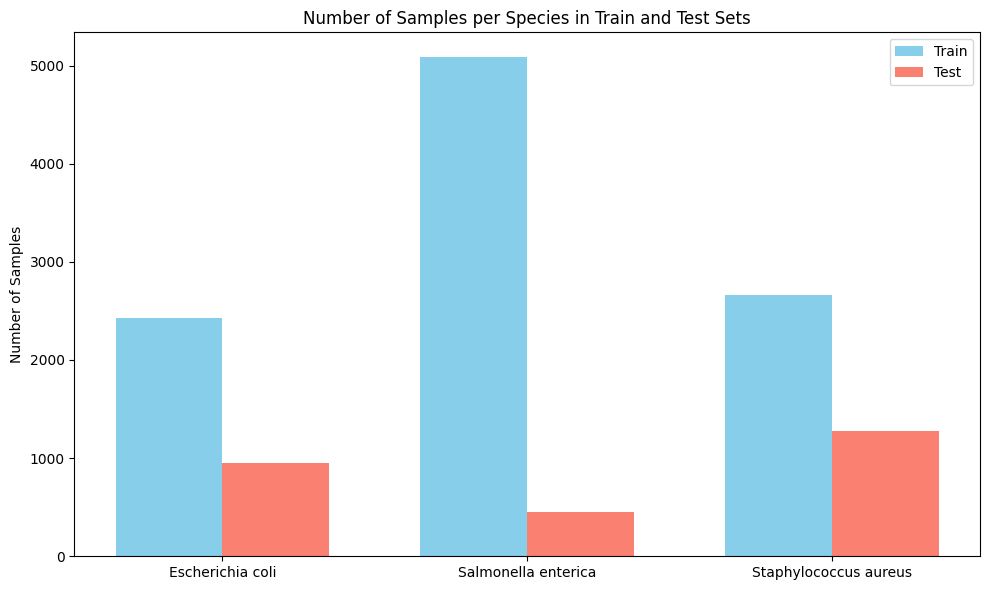

In [ ]:
# Filter the train and test sets based on the clusters
train_df = table_df[table_df['clusters'].isin(train_clusters)]
test_df = table_df[table_df['clusters'].isin(test_clusters)]

# Count the number of samples per species
train_counts = train_df['Species'].value_counts().sort_index()
test_counts = test_df['Species'].value_counts().sort_index()

# Ensure both have the same index (species)
all_species = sorted(set(train_counts.index).union(set(test_counts.index)))
train_counts = train_counts.reindex(all_species, fill_value=0)
test_counts = test_counts.reindex(all_species, fill_value=0)

# Plotting
x = range(len(all_species))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], train_counts, width=width, label='Train', color='skyblue')
plt.bar([i + width/2 for i in x], test_counts, width=width, label='Test', color='salmon')

plt.xticks(ticks=x, labels=all_species, rotation=0)
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Species in Train and Test Sets')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
train_counts

,count
Species,
Escherichia coli,2425
Salmonella enterica,5084
Staphylococcus aureus,2667


In [ ]:
test_counts

,count
Species,
Escherichia coli,951
Salmonella enterica,455
Staphylococcus aureus,1276


In [ ]:
# Group the DataFrame by cluster and count unique species in each cluster
species_per_cluster = table_df.groupby('clusters')['Species'].nunique()

# Find clusters with more than one unique species
multi_species_clusters = species_per_cluster[species_per_cluster > 1]

# Print them
if not multi_species_clusters.empty:
    print("Clusters with multiple species found:")
    print(multi_species_clusters)
    # Optionally, show which species are in those clusters
    for cluster_id in multi_species_clusters.index:
        species = table_df[table_df['clusters'] == cluster_id]['Species'].unique()
        print(f"Cluster {cluster_id} contains species: {species}")
else:
    print("All clusters contain only one species.")


All clusters contain only one species.


In [ ]:
len(test_df)

2682

In [ ]:
len(test_df) / (len(train_df) + len(test_df)) * 100

20.858609426038264